In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_squared_log_error
import matplotlib.pyplot as plt
from utils import preprocess_copy

df = pd.read_csv("./data/train.csv")
df = preprocess_copy(df)

In [2]:
# 特征列表
features = [
    'distance_km',
    'pickup_latitude', 'pickup_longitude',
    'dropoff_latitude', 'dropoff_longitude',
    'pickup_hour',
    'passenger_count',
    'vendor_id'
]

# X 和 y
X = df[features]
y = df['trip_duration']

# 对 trip_duration 做对数变换 (RMSLE 对数技巧)
y_log = np.log1p(y)

# 划分训练集/验证集
X_train, X_val, y_train, y_val = train_test_split(X, y_log, test_size=0.2, random_state=42)


In [3]:
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

In [4]:
params = {
    'objective': 'regression',
    'metric': 'rmse',  # 对数误差已处理在 y_log
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': -1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'seed': 42
}


In [7]:
model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[train_data, val_data],
)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004284 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 1166915, number of used features: 8
[LightGBM] [Info] Start training from score 6.466707


In [8]:
# 验证集预测
y_val_pred_log = model.predict(X_val)
y_val_pred = np.expm1(y_val_pred_log)  # 对数逆变换

# 原始 RMSLE 计算
rmsle = np.sqrt(mean_squared_log_error(np.expm1(y_val), y_val_pred))
print("Validation RMSLE:", rmsle)


Validation RMSLE: 0.4226616652012385


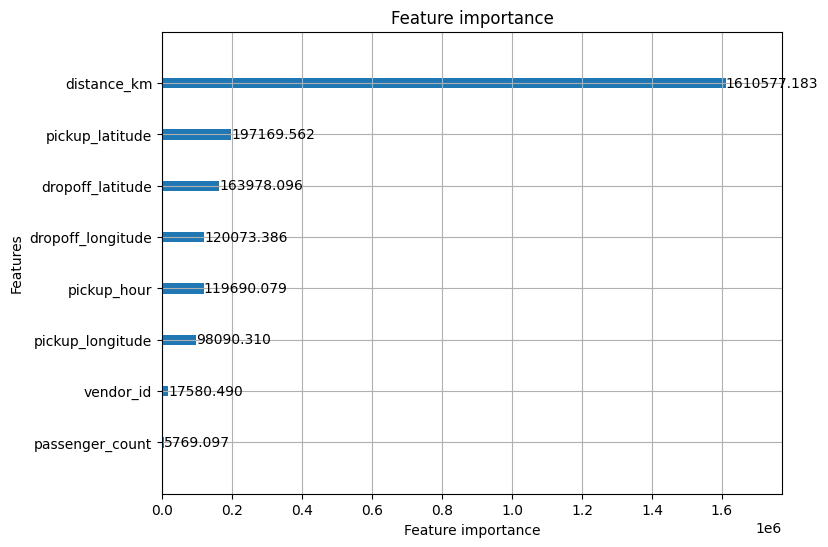

In [9]:
lgb.plot_importance(model, max_num_features=10, importance_type='gain', figsize=(8,6))
plt.show()


In [11]:
from utils import haversine
df_test = pd.read_csv("./data/test.csv")
df_test["distance_km"] = haversine(
    df_test["pickup_longitude"], df_test["pickup_latitude"],
    df_test["dropoff_longitude"], df_test["dropoff_latitude"]
)
df_test["pickup_hour"] = pd.to_datetime(df_test["pickup_datetime"]).dt.hour


In [14]:
X_test = df_test[features]
y_test_pred_log = model.predict(X_test)
y_test_pred = np.expm1(y_test_pred_log)
submission = pd.DataFrame({
    'id': df_test['id'],
    'trip_duration': y_test_pred
})
submission.to_csv('submission.csv', index=False)